## Uber demand forecasting for New York City
This is a short example to demonstrate the different and subsequent steps of a machine learning project.<br>
The goal of the project is to predict the demand of uber services in advance. 

### Setup

Import necessary libraries.

In [1]:
import os
import numpy as np
import pandas as pd

import json
# from area import area
from matplotlib import path

%matplotlib inline
from matplotlib import pyplot as plt

Set the number of CPUs to be used.

In [2]:
# value 1 -> use 1 CPU
# value 2 -> use 2 CPUs ...
# value -1 -> use all CPUs
# value -2 -> use all but one CPU ...
n_cpus = -2

### Get the data
Get the data for the Uber pickups for NYC for the time period April to September 2014 from the following sources:
```txt
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv

```

In [3]:
import urllib

# source from where to download the data
SOURCE_ROOT = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/'

# dictionary of the files to be downloaded
month_url = {'april_data' :'uber-raw-data-apr14.csv', 'may_data' :'uber-raw-data-may14.csv',
            'june_data' :'uber-raw-data-jun14.csv', 'july_data' :'uber-raw-data-jul14.csv',
            'august_data' :'uber-raw-data-aug14.csv', 'september_data' :'uber-raw-data-sep14.csv'}

# path to store the downloaded data
SAVING_PATH = os.path.join('datasets')

# function to fetch the data
def download_and_save_data(data_source_url = SOURCE_ROOT, data_path = SAVING_PATH):
    # make data directory if not existing
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
        # get data csv for each month
        for month in month_url:
            data_url = ''
            file_name = month_url[month]

            # status print
            print('download and save {}'.format(file_name))

            # setup the data url
            data_url = data_source_url + file_name

            # specify the douwnload file
            csv_path = os.path.join(data_path, file_name)

            # receive the data from the web
            urllib.request.urlretrieve(data_url, csv_path)

# call the function to download and save the data
download_and_save_data()

Convert the `CSV` files into a pandas `DataFrame` files and store them in a dictionary.

In [4]:
def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

In [5]:
data_dict = {}

for month in month_url:
    csv_filename = month_url[month]
    csv_path = os.path.join(SAVING_PATH, csv_filename)
    pd_filename = month
    data_dict.update({pd_filename : load_csv_data(csv_path)})

In [6]:
data_dict.keys()

dict_keys(['april_data', 'may_data', 'june_data', 'july_data', 'august_data', 'september_data'])

Load data frames

In [7]:
TRAIN_ON_WHOLE_DATA = True

In [8]:
if TRAIN_ON_WHOLE_DATA:
    frames = [data_dict['april_data'], data_dict['may_data'], 
              data_dict['june_data'], data_dict['july_data'], data_dict['august_data']]
    x = pd.concat(frames, ignore_index=True)
else:
    x = data_dict['april_data']

In [9]:
x

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
3506186,8/31/2014 23:55:00,40.7552,-73.9753,B02764
3506187,8/31/2014 23:55:00,40.7552,-73.9753,B02764
3506188,8/31/2014 23:55:00,40.7617,-73.9788,B02764
3506189,8/31/2014 23:59:00,40.7395,-73.9889,B02764


## Analise the raw data

Print the first ten data rows.

In [10]:
x.head(10)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
5,4/1/2014 0:33:00,40.7383,-74.0403,B02512
6,4/1/2014 0:39:00,40.7223,-73.9887,B02512
7,4/1/2014 0:45:00,40.7620,-73.9790,B02512
8,4/1/2014 0:55:00,40.7524,-73.9960,B02512
9,4/1/2014 1:01:00,40.7575,-73.9846,B02512


The data consists of four columns with five parameters:

`Data`: The date of the Uber pickup.
<br>
`Time`: The time of the Uber pickup.
<br>
`Lat`: The latitude of the Uber pickup.
<br>
`Lon`: The longitude of the Uber pickup.
<br>
`Base`: The TLC base company code affiliated with the Uber pickup.

Check the amount and completeness of the data point.

In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3506191 entries, 0 to 3506190
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 107.0+ MB


There are 3.506.191 entries with no missing data point.

`Lon` ans `Lat` are of *float64* data type. These values can be used after scaling them (see later) without further preprocessing. 

`Date/Time` is of type *object* and therefore needs to be converted into a time series format.

`Base` is also of type *object*. We will use one-hot-encoding here.

Lets have a closer look at the `Base` parameter.

In [12]:
x['Base'].value_counts()

B02598    1152513
B02617    1081158
B02682    1015651
B02512     171303
B02764      85566
Name: Base, dtype: int64

The `Base` parameter has five different values.

## Preprocess the data

### Add the label parameter
Add a new parameter `pickups` to count the number of pickups. **This will be the label!**

In [13]:
x['Pickups'] = 1

In [14]:
x.head()

,Date/Time,Lat,Lon,Base,Pickups
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1


### Add new parameter `Neighborhood` to cluster the longitude and latitude into spatial clusters 
Add an additional column for a new parameter called *neighborhood*. This column stores the neighborhoods of NYC generated out of the latitude and longitude values.

In [15]:
x_add = x.copy()

In [16]:
x_add['Neighborhood'] = np.zeros(len(x_add))

In [17]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,0.0
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1,0.0
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,0.0
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,0.0
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,0.0
...,...,...,...,...,...,...
3506186,8/31/2014 23:55:00,40.7552,-73.9753,B02764,1,0.0
3506187,8/31/2014 23:55:00,40.7552,-73.9753,B02764,1,0.0
3506188,8/31/2014 23:55:00,40.7617,-73.9788,B02764,1,0.0
3506189,8/31/2014 23:59:00,40.7395,-73.9889,B02764,1,0.0


Load a JSON file with the *latitude / longitude* to *neighborhood* correlation.

In [18]:
geofile = json.load(open("NY_neighborhoods.geojson"))

In [19]:
geo_points = list(zip(x_add['Lon'], x_add['Lat']))

In [20]:
if os.path.isfile('datasets/training_data_neighborhood.csv'):
    x_add = load_csv_data('datasets/training_data_neighborhood.csv')
    
else:
    for feature in geofile['features']:
        coords = feature['geometry']['coordinates'][0]
        p = path.Path(coords)
        inds = p.contains_points(geo_points)
        list_neighborhoods = [str(feature['properties']['neighborhood'])]*np.sum(inds)
        x_add.loc[x_add.index[inds], 'Neighborhood'] = list_neighborhoods

In [21]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,Upper East Side
1,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,East Village
2,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,Midtown
3,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,Midtown
4,4/1/2014 0:39:00,40.7223,-73.9887,B02512,1,Lower East Side
...,...,...,...,...,...,...
3412742,8/31/2014 23:55:00,40.7552,-73.9753,B02764,1,Midtown
3412743,8/31/2014 23:55:00,40.7552,-73.9753,B02764,1,Midtown
3412744,8/31/2014 23:55:00,40.7617,-73.9788,B02764,1,Midtown
3412745,8/31/2014 23:59:00,40.7395,-73.9889,B02764,1,Flatiron District


Remove all non-matching entries. These were entries with pickups outside of central NYC.

In [22]:
x_add = x_add[x_add['Neighborhood'] != 0]

In [23]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,Upper East Side
1,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,East Village
2,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,Midtown
3,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,Midtown
4,4/1/2014 0:39:00,40.7223,-73.9887,B02512,1,Lower East Side
...,...,...,...,...,...,...
3412742,8/31/2014 23:55:00,40.7552,-73.9753,B02764,1,Midtown
3412743,8/31/2014 23:55:00,40.7552,-73.9753,B02764,1,Midtown
3412744,8/31/2014 23:55:00,40.7617,-73.9788,B02764,1,Midtown
3412745,8/31/2014 23:59:00,40.7395,-73.9889,B02764,1,Flatiron District


In [24]:
x_add['Neighborhood'].value_counts()

Midtown                       530810
Chelsea                       270140
Upper East Side               267482
Upper West Side               164515
West Village                  163077
                               ...  
Charleston                         1
Pleasant Plains                    1
Bay Terrace, Staten Island         1
Huguenot                           1
Prince's Bay                       1
Name: Neighborhood, Length: 252, dtype: int64

There are 252 listed neighborhood. One should check if these neighborhood are correct. But I will not do it for now.

### Safe the data
Safe the current DataFrame.

In [25]:
if os.path.isfile('datasets/training_data_neighborhood.csv') == False:
    x_add.to_csv('datasets/training_data_neighborhood.csv', index=False)

### Convert `Date/Time` into a time series format
Extract the `Date/Time` parameter column to convert it into a **time series format**.

In [26]:
x_timeseries = x_add.copy()

In [27]:
x_timeseries.index = pd.to_datetime(x_timeseries['Date/Time'])
x_timeseries.sort_index(inplace=True)
x_timeseries.drop(labels=['Date/Time'], axis=1, inplace=True)

In [28]:
x_timeseries

,Lat,Lon,Base,Pickups,Neighborhood
Date/Time,,,,,
2014-04-01 00:00:00,40.7188,-73.9863,B02598,1,Lower East Side
2014-04-01 00:00:00,40.7637,-73.9600,B02598,1,Upper East Side
2014-04-01 00:00:00,40.7215,-73.9952,B02682,1,Nolita
2014-04-01 00:01:00,40.7355,-73.9966,B02617,1,Greenwich Village
2014-04-01 00:02:00,40.7556,-73.9874,B02598,1,Theater District
...,...,...,...,...,...
2014-08-31 23:59:00,40.8924,-73.9107,B02682,1,Riverdale
2014-08-31 23:59:00,40.6448,-73.7818,B02682,1,John F. Kennedy International Airport
2014-08-31 23:59:00,40.6466,-73.7894,B02617,1,John F. Kennedy International Airport


### Delete unnecessary parameters
Now that we have the new neighborhood parameter, we do not need `Lat` and `Lon` any more. These two parameter columns will be deleted. 

As we do not pay further attention to the `Base` parameter, this column will also be deleted but in other scenarios the `Base` can be very important.

In [29]:
x_neighbor = x_timeseries.drop(['Lat', 'Lon', 'Base'], axis = 1)
x_neighbor

,Pickups,Neighborhood
Date/Time,,
2014-04-01 00:00:00,1,Lower East Side
2014-04-01 00:00:00,1,Upper East Side
2014-04-01 00:00:00,1,Nolita
2014-04-01 00:01:00,1,Greenwich Village
2014-04-01 00:02:00,1,Theater District
...,...,...
2014-08-31 23:59:00,1,Riverdale
2014-08-31 23:59:00,1,John F. Kennedy International Airport
2014-08-31 23:59:00,1,John F. Kennedy International Airport


### Cluster the data into one hour intervals
Cluster the data within time intervals of one hour.

In [30]:
x_cluster = x_neighbor.resample('H').agg({'Pickups' : 'sum', 'Neighborhood': 'nunique'})

In [31]:
x_cluster

,Pickups,Neighborhood
Date/Time,,
2014-04-01 00:00:00,132,38
2014-04-01 01:00:00,66,26
2014-04-01 02:00:00,51,22
2014-04-01 03:00:00,87,41
2014-04-01 04:00:00,157,47
...,...,...
2014-08-31 19:00:00,1292,105
2014-08-31 20:00:00,1205,112
2014-08-31 21:00:00,1361,100


### Extend the data by weekdays, weekend check and hours of the day

In [32]:
x_cluster['Weekday'] = x_cluster.index.weekday
x_cluster['Is_weekend'] = x_cluster.index.map(lambda x: 1 if x.weekday() > 4 else 0)
x_cluster['Hour_of_day'] = x_cluster.index.hour
x_cluster

,Pickups,Neighborhood,Weekday,Is_weekend,Hour_of_day
Date/Time,,,,,
2014-04-01 00:00:00,132,38,1,0,0
2014-04-01 01:00:00,66,26,1,0,1
2014-04-01 02:00:00,51,22,1,0,2
2014-04-01 03:00:00,87,41,1,0,3
2014-04-01 04:00:00,157,47,1,0,4
...,...,...,...,...,...
2014-08-31 19:00:00,1292,105,6,1,19
2014-08-31 20:00:00,1205,112,6,1,20
2014-08-31 21:00:00,1361,100,6,1,21


**Conclusion**: Now we can see, that on April the 1st 2014 between midnight and 1 am where 132 pickups distributed between 38 neighborhoods. It is a Thursday, thus not a weekend and its the first hour of the day.

## Analise and visualize the preprocessed data
### Distribution plots

Plot the `Pickups` distribution for April 2014.

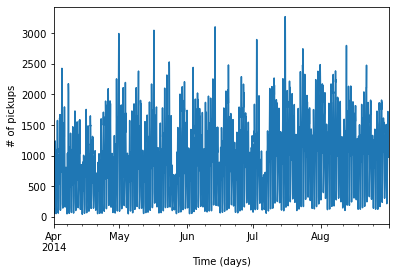

In [33]:
ax = x_cluster['Pickups'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (days)');

Plot the `Neighborhood` distribution for April 2014.

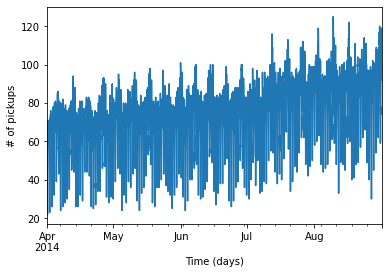

In [34]:
ax = x_cluster['Neighborhood'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (days)');

Plot the `Pickups` distribution for April the 1st 2014.

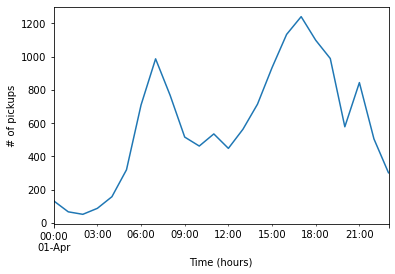

In [35]:
ax = x_cluster.loc['2014-04-01', 'Pickups'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (hours)');

Plot the `Neighborhood` distribution for April the 1st 2014.

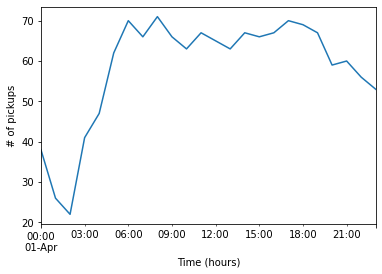

In [36]:
ax = x_cluster.loc['2014-04-01', 'Neighborhood'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (hours)');

### Data analysis
Analise the preprocessed data.

In [37]:
x_cluster.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3672 entries, 2014-04-01 00:00:00 to 2014-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Pickups       3672 non-null   int64
 1   Neighborhood  3672 non-null   int64
 2   Weekday       3672 non-null   int64
 3   Is_weekend    3672 non-null   int64
 4   Hour_of_day   3672 non-null   int64
dtypes: int64(5)
memory usage: 332.1 KB


In [38]:
x_cluster['Pickups'].describe()

count    3672.000000
mean      929.397331
std       571.607234
min        44.000000
25%       446.750000
50%       893.000000
75%      1318.250000
max      3271.000000
Name: Pickups, dtype: float64

### Correlations
Compute the ***standard correlation coefficient*** between the different **numerical attributes**.

In [39]:
corr_matrix = x_cluster.corr()
corr_matrix

,Pickups,Neighborhood,Weekday,Is_weekend,Hour_of_day
Pickups,1.000000,0.724893,-4.629113e-02,-1.619481e-01,6.489427e-01
Neighborhood,0.724893,1.000000,1.897081e-01,1.597209e-01,5.512595e-01
Weekday,-0.046291,0.189708,1.000000e+00,7.912357e-01,1.403514e-19
Is_weekend,-0.161948,0.159721,7.912357e-01,1.000000e+00,3.087920e-19
Hour_of_day,0.648943,0.551260,1.403514e-19,3.087920e-19,1.000000e+00


There is a high correlation between the number of pickups and the number of neighborhoods of 0.72.

##### Plot the correlations
Plot the correlations between the attributes: `Pickups` and `Neighborhood`. Use [`pandas.plotting.scatter_matrix`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) for plotting the correlations.

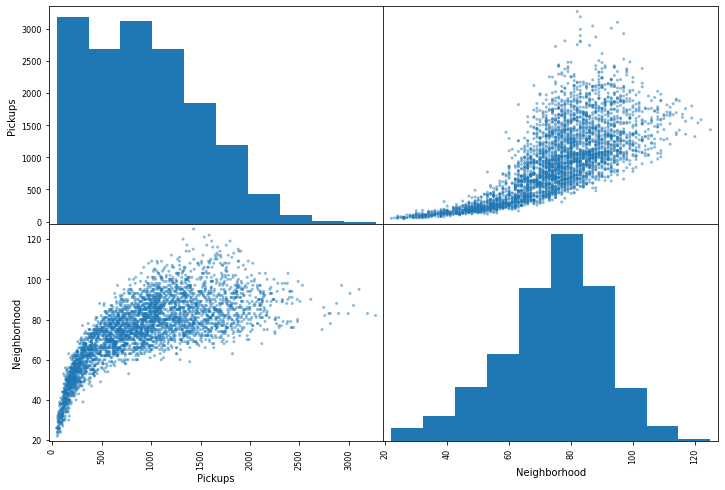

In [40]:
from pandas.plotting import scatter_matrix

attributes = ['Pickups', 'Neighborhood']
scatter_matrix(x_cluster[attributes], figsize=(12,8))
plt.show()

### Conclusion 
1. There is a clear correlation between time of day and number of pickups.
2. There is also a clear correlation between time of day and number of neighborhoods. 
3. There is a clear, polynomial correlation between the number of neighborhoods and the number of pickups.

### Further improvements
For better predictions the data should/could be extended by the following attributes:
1. Is it a holiday
2. Is it raining
3. Outside temperature

### Outlook 
The above mentioned correlations enable us to use machine learning models to predict the amount of pickups dependent on the time of day.

The problem we have to solve is a **regression problem**. We have to find the best approximation between the `Date/Time`, the `Neighborhood` and the `Pickups` attributes.

## Prepare the data for machine learning algorithms

### Split labels from training set
Drop the labels from the training set and move them into the "label set".

In [41]:
x_cluster.head()

,Pickups,Neighborhood,Weekday,Is_weekend,Hour_of_day
Date/Time,,,,,
2014-04-01 00:00:00,132,38,1,0,0
2014-04-01 01:00:00,66,26,1,0,1
2014-04-01 02:00:00,51,22,1,0,2
2014-04-01 03:00:00,87,41,1,0,3
2014-04-01 04:00:00,157,47,1,0,4


In [42]:
X_train = x_cluster.drop('Pickups', axis = 1)
y_train = x_cluster['Pickups'].copy()

In [43]:
X_train.head()

,Neighborhood,Weekday,Is_weekend,Hour_of_day
Date/Time,,,,
2014-04-01 00:00:00,38,1,0,0
2014-04-01 01:00:00,26,1,0,1
2014-04-01 02:00:00,22,1,0,2
2014-04-01 03:00:00,41,1,0,3
2014-04-01 04:00:00,47,1,0,4


### Missing values
Check for missing values within the attributes.

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3672 entries, 2014-04-01 00:00:00 to 2014-08-31 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Neighborhood  3672 non-null   int64
 1   Weekday       3672 non-null   int64
 2   Is_weekend    3672 non-null   int64
 3   Hour_of_day   3672 non-null   int64
dtypes: int64(4)
memory usage: 303.4 KB


There are no missing values for the attributes.

In the case of missing values there are three possibilities to handle them:
* delete the entries with the missing values
* delete the hole attribute with the missing values
* fill the missing values with the median value of that attribute

Use `sklearn.impute.SimpleImputer` class for replacing missing values if necessary.

### Categorical attributes
Although there are no categorical attributes, the attribute `Weekday` and `Hour_of_day` have to be altered because they have growing values. Thus a machine learning algorithm may interpret larger values as more important, than smaller values. We will eliminate this by converting the numbers into categories and then using one-hot-encoder on the categorical values.

In [45]:
map_dict_weekday = {0: "Mon", 1: "Tue", 2: "Wen", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
X_train['Day_of_week'] = X_train['Weekday'].map(map_dict_weekday)
X_train.drop(labels=['Weekday'], axis=1, inplace=True)
X_train

,Neighborhood,Is_weekend,Hour_of_day,Day_of_week
Date/Time,,,,
2014-04-01 00:00:00,38,0,0,Tue
2014-04-01 01:00:00,26,0,1,Tue
2014-04-01 02:00:00,22,0,2,Tue
2014-04-01 03:00:00,41,0,3,Tue
2014-04-01 04:00:00,47,0,4,Tue
...,...,...,...,...
2014-08-31 19:00:00,105,1,19,Sun
2014-08-31 20:00:00,112,1,20,Sun
2014-08-31 21:00:00,100,1,21,Sun


In [46]:
map_dict_hour = {0: "H_1", 1: "H_2", 2: "H_3", 3: "H_4", 4: "H_5", 5: "H_6", 6: "H_7", 7: "H_8",
                8: "H_9", 9: "H_10", 10: "H_11", 11: "H_12", 12: "H_13", 13: "H_14", 14: "H_15", 15: "H_16",
                16: "H_17", 17: "H_18", 18: "H_19", 19: "H_20", 20: "H_21", 21: "H_22", 22: "H_23", 23: "H_24"}
                
X_train['Hours'] = X_train['Hour_of_day'].map(map_dict_hour)
X_train.drop(labels=['Hour_of_day'], axis=1, inplace=True)
X_train

,Neighborhood,Is_weekend,Day_of_week,Hours
Date/Time,,,,
2014-04-01 00:00:00,38,0,Tue,H_1
2014-04-01 01:00:00,26,0,Tue,H_2
2014-04-01 02:00:00,22,0,Tue,H_3
2014-04-01 03:00:00,41,0,Tue,H_4
2014-04-01 04:00:00,47,0,Tue,H_5
...,...,...,...,...
2014-08-31 19:00:00,105,1,Sun,H_20
2014-08-31 20:00:00,112,1,Sun,H_21
2014-08-31 21:00:00,100,1,Sun,H_22


Use the parameters `Is_weekend`, `Day_of_week` and `Hours` for training.

In [47]:
X_train_prep = X_train[['Is_weekend', 'Day_of_week', 'Hours']].copy()

In [48]:
X_train_prep.reset_index(drop=True)

,Is_weekend,Day_of_week,Hours
0,0,Tue,H_1
1,0,Tue,H_2
2,0,Tue,H_3
3,0,Tue,H_4
4,0,Tue,H_5
...,...,...,...
3667,1,Sun,H_20
3668,1,Sun,H_21
3669,1,Sun,H_22
3670,1,Sun,H_23


#### One-Hot-Encoder
Create a binary attribute for each "value" within the categorical attribute using the `OneHotEncoder`. Transform the categorical values of the attribute `Day_of_week` and `Hours` into binary values (0 or 1). The result is a matrix with `n` columns representing the `n` different categorical values. 

In [49]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

One-hot-encoding for the `Day_of_week` attribute.

In [50]:
X_train_cat_days = X_train_prep[['Day_of_week']]

In [51]:
X_train_cat_days_1hot = one_hot_encoder.fit_transform(X_train_cat_days)
X_train_cat_days_1hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

One-hot-encoding for the `Hours` attribute.

In [52]:
X_train_cat_hours = X_train_prep[['Hours']]

In [53]:
X_train_cat_hours_1hot = one_hot_encoder.fit_transform(X_train_cat_hours)
X_train_cat_hours_1hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Convert the `Is_weekend` attribute into an array.

In [54]:
Is_weekend_array = np.expand_dims(np.asarray(X_train_prep['Is_weekend']), axis=1)
Is_weekend_array.shape

(3672, 1)

Concatenate the three resulting arrays to get the training input array.

In [55]:
result = np.concatenate((Is_weekend_array, X_train_cat_days_1hot, X_train_cat_hours_1hot), axis=1)
result.shape

(3672, 32)

In [56]:
X_train_prep = pd.DataFrame(result)
X_train_prep

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3668,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3669,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3670,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
X_train_prep.shape

(3672, 32)

**Now the training data has been prepared for machine learning!**

* The data has been fetched and loaded.
* The data has been analyzed.
* The data has been split into a training and a testing set. A stratified split has been used for this purpose. 
* The data has been visualized to get further insights into it.
* The correlation between the numerical attributed has been performed.
* Additional attributes have been added.
* Separate the "label" from the training data.
* Check for and handle missing (numerical) values within the attributes.
* Preprocess categorical attributes by one-hot-encoder.

**Results of the preprocessing steps:**
* `X_train_prep`: the prepared training data
* `y_train`:    the labeled data for training

## Select and train a model

**Linear regression model:** [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [58]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression().fit(X_train_prep, y_train)
linReg.score(X_train_prep, y_train)

0.6812547575653884

**Random forest model:** [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [59]:
from sklearn.ensemble import RandomForestRegressor

randForestReg = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs=n_cpus)
randForestReg.fit(X_train_prep, y_train)

RandomForestRegressor(n_jobs=-2, random_state=42)

In [60]:
randForestReg.score(X_train_prep, y_train)

0.8258485731619142

**Support vector machine model:**[`SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

In [61]:
from sklearn.svm import SVR

svmReg = SVR(kernel='linear')
svmReg.fit(X_train_prep, y_train)

SVR(kernel='linear')

In [62]:
svmReg.score(X_train_prep, y_train)

0.2779418455977839